In [ ]:
!pip install tensorflow keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Data processing and visualization imports
import string
import pandas as pd
import plotly.express as px
import tensorflow.data as tfd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model building imports
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
from tensorflow.keras import Model, layers

In [ ]:
num_heads = 4
embed_dim = 256
ff_dim = 128
vocab_size = 10000
max_seq_len = 40

# Set constants
learning_rate = 1e-3
epochs = 100
batch_size = 32

# Define training callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("SpamDetector.h5", save_best_only=True)
]

In [ ]:
random_seed = 123
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
import pandas as pd

# Load the dataset using pandas, specifying the encoding as 'latin-1'
data_frame = pd.read_csv('spam.csv', encoding='latin-1')
data_frame.rename(columns = {'v1':'Category','v2':'Messages'},inplace=True)

# Print the first five rows of the dataset
print(data_frame.head())

  Category                                           Messages Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [ ]:

class_dis = data_frame.Category.value_counts()
class_names = class_dis.index

# Create the Pie Chart
fig = px.pie(names=class_names,
             values=class_dis,
             color=class_names,
             hole=0.4,
             labels={'value': 'Count', 'names': 'Class'},
             title='Class Distribution of Spam Text Messages')

# Customize the layout
fig.update_layout(
    margin=dict(l=10, r=10, t=60, b=10),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)

# Show the plot
fig.show()


In [ ]:
N_SAMPLES = len(data_frame)

print(f"Total Number of Samples : {N_SAMPLES}")

Total Number of Samples : 5572


In [ ]:
max_len = max([len(text) for text in data_frame.Messages])
print(f"Maximum Length Of Input Sequence(Chars) : {max_len}")

Maximum Length Of Input Sequence(Chars) : 910


In [ ]:
X = data_frame['Messages'].tolist()
y = data_frame['Category'].tolist()


# Initialize label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Print the first 5 elements of X and y
print(f'X[:5]: \n{X[:5]}\n')
print(f'y[:5]: {y[:5]}\n')
print(f"Label Mapping : {label_encoder.inverse_transform(y[:5])}")


X[:5]: 
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though"]

y[:5]: [0 0 1 0 0]

Label Mapping : ['ham' 'ham' 'spam' 'ham' 'ham']


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=data_frame.Category.unique(), y=label_encoder.inverse_transform(y))
class_weights = {number: weight for number, weight in enumerate(class_weights)}
# Show
print(f"Associated class weights: {class_weights}")

Associated class weights: {0: np.float64(0.5774093264248704), 1: np.float64(3.7295850066934406)}


In [ ]:
def preprocess_text(text: str) -> str:
    """
    Preprocesses the text by removing punctuation, lowercasing, and stripping whitespace.
    """
    # Replace punctuation with spaces
    text = tf.strings.regex_replace(text, f"[{string.punctuation}]", " ")

    # Lowercase the text
    text = tf.strings.lower(text)

    # Strip leading/trailing whitespace
    text = tf.strings.strip(text)

    return text


# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,                       # Maximum vocabulary size
    output_sequence_length=max_seq_len,          # Maximum sequence length
    standardize=preprocess_text,                 # Custom text preprocessing function
    pad_to_max_tokens=True,                      # Pad sequences to maximum length
    output_mode='int'                            # Output integer-encoded sequences
)

# Adapt the TextVectorization layer to the data
text_vectorizer.adapt(X)

In [ ]:
for _ in range(5):
    # Send a text to randomly.
    text_temp = X[np.random.randint(N_SAMPLES)]

    # Apply text to vectorization.
    text_vec_temp = text_vectorizer(text_temp)

    # Show the results
    print(f"Original Text: {text_temp}")
    print(f"Vectorized Text: {text_vec_temp}\n")

Original Text: I sent your maga that money yesterday oh.
Vectorized Text: [   2  197   15 2578   19  229  513  136    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]

Original Text: No need lar. Jus testing e phone card. Dunno network not gd i thk. Me waiting 4 my sis 2 finish bathing so i can bathe. Dun disturb u liao u cleaning ur room.
Vectorized Text: [  42   81  342  365 3108  152  116  702  421  441   29  659    2  267
   11  257   45   12  682   22  316 2211   26    2   25 1075  252 1152
    7  349    7 2181   40  371    0    0    0    0    0    0]

Original Text: Is it ok if I stay the night here? Xavier has a sleeping bag and I'm getting tired
Vectorized Text: [  10   13   50   37    2  528    6  127  117 2298  126    5  600 1450
    8    2   30  278  832    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]

Origi

In [ ]:
VOCAB = text_vectorizer.get_vocabulary()

# Let's have a look at the tokens present in the vocabulary
print(f"Vocabulary size: {len(VOCAB)}")
print(f"Vocabulary: {VOCAB[150:200]}")

Vocabulary size: 8862
Vocabulary: [np.str_('should'), np.str_('message'), np.str_('e'), np.str_('won'), np.str_('ve'), np.str_('tomorrow'), np.str_('prize'), np.str_('say'), np.str_('right'), np.str_('already'), np.str_('after'), np.str_('ask'), np.str_('said'), np.str_('doing'), np.str_('cash'), np.str_('yeah'), np.str_('3'), np.str_('really'), np.str_('amp'), np.str_('why'), np.str_('meet'), np.str_('b'), np.str_('them'), np.str_('im'), np.str_('very'), np.str_('find'), np.str_('life'), np.str_('let'), np.str_('babe'), np.str_('last'), np.str_('thanks'), np.str_('morning'), np.str_('\\'), np.str_('would'), np.str_('cos'), np.str_('win'), np.str_('miss'), np.str_('uk'), np.str_('lol'), np.str_('anything'), np.str_('also'), np.str_('every'), np.str_('sure'), np.str_('pick'), np.str_('com'), np.str_('care'), np.str_('150p'), np.str_('sent'), np.str_('nokia'), np.str_('urgent')]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Apply the Text Vectorization
X_train = text_vectorizer(X_train)
X_test = text_vectorizer(X_test)

# One Hot Vectors
Xoh_train = tf.one_hot(X_train, depth=10000)
Xoh_test  = tf.one_hot(X_test, depth=10000)

In [ ]:
class TokenAndPositionalEmbedding(layers.Layer):

    def __init__(self, embedding_dims, vocab_size, seq_len, **kwargs):
        super(TokenAndPositionalEmbedding, self).__init__(**kwargs)

        # Initialize parameters
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embedding_dims = embedding_dims
        self.embed_scale = tf.math.sqrt(tf.cast(embedding_dims, tf.float32))

        # Define layers
        self.token_embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dims,
            name="token_embedding"
        )

        self.positional_embedding = layers.Embedding(
            input_dim=seq_len,
            output_dim=embedding_dims,
            name="positional_embedding"
        )

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]

        # Token Embedding
        token_embedding = self.token_embedding(inputs)
        token_embedding *= self.embed_scale

        # Positional Embedding
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_embedding = self.positional_embedding(positions)

        # Add Token and Positional Embedding
        embeddings = token_embedding + positional_embedding

        return embeddings


    def get_config(self):
        config = super(TokenAndPositionalEmbedding, self).get_config()
        config.update({
            'embedding_dims': self.embedding_dims,
            'vocab_size': self.vocab_size,
            'seq_len': self.seq_len,
        })
        return config

In [ ]:
temp_embeds = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len)(X_train[:1])
temp_embeds

<tf.Tensor: shape=(1, 40, 256), dtype=float32, numpy=
array([[[ 0.14969139, -0.2681547 , -0.33095762, ..., -0.11310659,
         -0.3961549 ,  0.39728665],
        [-0.31265795, -0.5884983 , -0.62283957, ...,  0.70162296,
          0.26370922, -0.7027314 ],
        [ 0.6824386 , -0.6212132 ,  0.5190754 , ..., -0.14940934,
         -0.70127267, -0.2942336 ],
        ...,
        [-0.3341118 , -0.72687155,  0.63899505, ..., -0.49248603,
          0.16664627,  0.45786434],
        [-0.32946473, -0.7207563 ,  0.6294834 , ..., -0.56620044,
          0.12218007,  0.40606484],
        [-0.29038626, -0.72068465,  0.6673166 , ..., -0.50073236,
          0.20926629,  0.47440535]]], dtype=float32)>

In [ ]:
class TransformerLayer(layers.Layer):

    def __init__(self, num_heads: int, dropout_rate: float, embedding_dims: int, ff_dim: int, **kwargs):
        super(TransformerLayer, self).__init__(**kwargs)

        # Initialize Parameters
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.embedding_dims = embedding_dims
        self.ff_dim = ff_dim

        # Initialize Layers
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims, dropout=dropout_rate)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(embedding_dims)
        ])
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        """Forward pass of the Transformer Layer.

        Args:
            inputs: Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the input sequence.

        Returns:
            Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the output sequence after applying the Transformer Layer.
        """

        # Multi-Head Attention
        attention = self.mha(inputs, inputs, inputs)

        # Layer Normalization and Residual Connection
        normalized1 = self.ln1(attention + inputs)

        # Feedforward Network
        ffn_out = self.ffn(normalized1)

        # Layer Normalization and Residual Connection
        normalized2 = self.ln2(ffn_out + normalized1)

        return normalized2

    def get_config(self):
        """Get the configuration of the Transformer Layer.

        Returns:
            Dictionary with the configuration of the layer.
        """
        config = super(TransformerLayer, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
            "embedding_dims": self.embedding_dims,
            "ff_dim": self.ff_dim
        })
        return config

In [ ]:
TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1)(temp_embeds)

<tf.Tensor: shape=(1, 40, 256), dtype=float32, numpy=
array([[[-0.83473164, -0.5507125 , -1.4140341 , ...,  1.0045748 ,
         -0.15838066, -0.36100826],
        [ 0.20425242, -0.8064618 , -1.4961003 , ...,  1.4933944 ,
          0.7064954 , -0.9044112 ],
        [ 0.30236757, -1.2575392 ,  1.0055813 , ...,  1.0510509 ,
         -0.2903014 , -1.1223813 ],
        ...,
        [-1.2131536 , -1.2899718 ,  1.5173503 , ..., -0.8203405 ,
          0.48369974,  0.8609394 ],
        [-1.2605426 , -1.3168942 ,  1.5457742 , ..., -0.8969656 ,
          0.40190566,  0.82172936],
        [-1.1455669 , -1.3460869 ,  1.6461573 , ..., -0.77084094,
          0.64632916,  0.8941743 ]]], dtype=float32)>

In [ ]:
InputLayer = layers.Input(shape=(max_seq_len,), name="InputLayer")

# Embedding Layer
embeddings = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len, name="EmbeddingLayer")(InputLayer)

# Transformer Layer
encodings = TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1, name="TransformerLayer")(embeddings)

# Classifier
gap = layers.GlobalAveragePooling1D(name="GlobalAveragePooling")(encodings)
drop = layers.Dropout(0.5, name="Dropout")(gap)
OutputLayer = layers.Dense(1, activation='sigmoid', name="OutputLayer")(drop)

# Model
model = keras.Model(InputLayer, OutputLayer, name="TransformerNet")

# Model Architecture Summary
model.summary()

Model: "TransformerNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingLayer                  │ (None, 40, 256)        │     2,570,240 │
│ (TokenAndPositionalEmbedding)   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TransformerLayer                │ (None, 40, 256)        │     1,118,848 │
│ (TransformerLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAveragePooling            │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,689,345 (14.07 MB)

 Trainable params: 3,689,345 (14.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]
)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 512ms/step - accuracy: 0.9943 - auc: 0.9993 - loss: 0.0244 - precision: 0.9618 - recall: 0.9944 - val_accuracy: 0.9888 - val_auc: 0.9832 - val_loss: 0.0627 - val_precision: 0.9848 - val_recall: 0.9420
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 80s 497ms/step - accuracy: 0.9985 - auc: 0.9997 - loss: 0.0080 - precision: 0.9882 - recall: 1.0000 - val_accuracy: 0.9865 - val_auc: 0.9779 - val_loss: 0.0860 - val_precision: 1.0000 - val_recall: 0.9130
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 491ms/step - accuracy: 0.9995 - auc: 1.0000 - loss: 0.0026 - precision: 0.9961 - recall: 1.0000 - val_accuracy: 0.9933 - val_auc: 0.9777 - val_loss: 0.0711 - val_precision: 1.0000 - val_recall: 0.9565
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0015 - precision: 0.9980 - recall: 1.0000 - val_accuracy: 0.9865 - val_auc: 0.9777 - val_loss: 0.0906 - val_precision: 1.0000 - val_recall: 0.9130


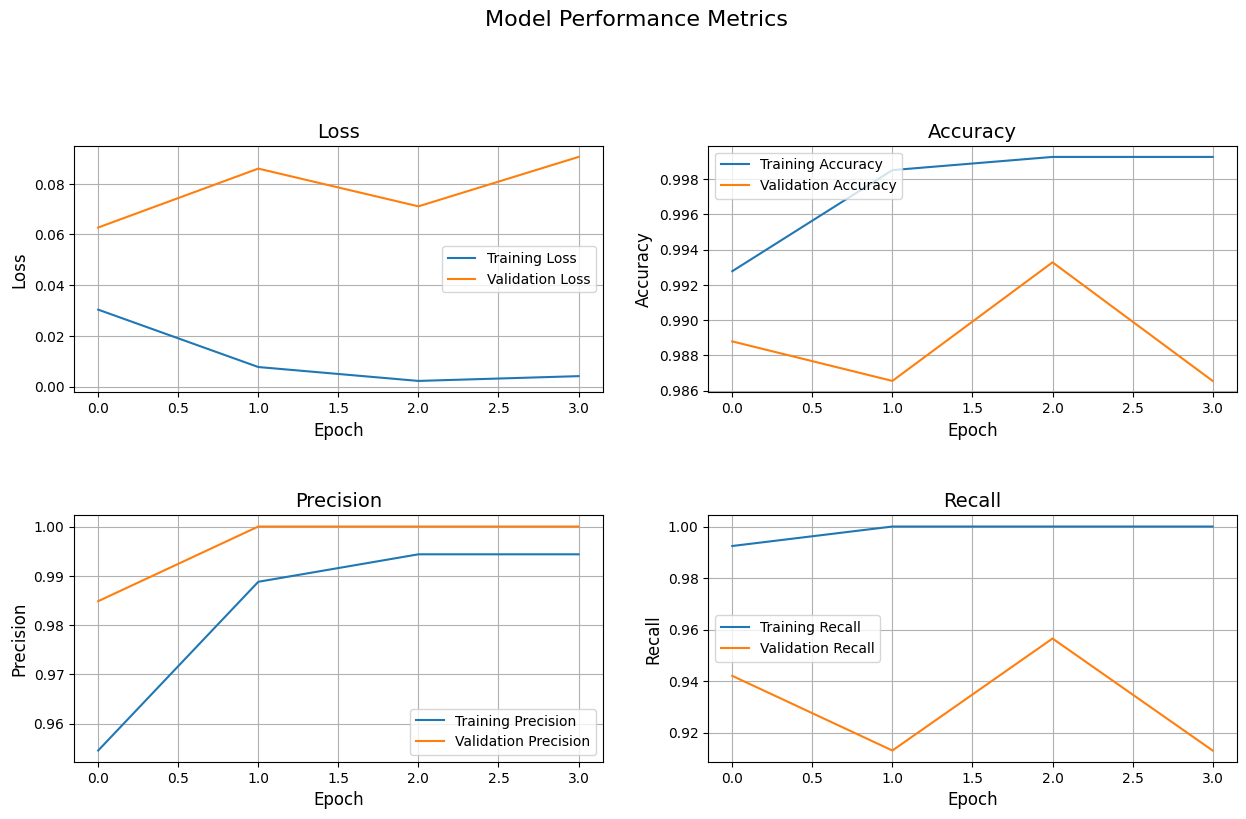

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].grid(True)
axes[0, 0].legend(fontsize=10)

axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].grid(True)
axes[0, 1].legend(fontsize=10)

axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].grid(True)
axes[1, 0].legend(fontsize=10)

axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].grid(True)
axes[1, 1].legend(fontsize=10)

fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)
plt.show()


In [ ]:
loss, acc, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)

# Show the model performance
print('Test loss      :', loss)
print('Test accuracy  :', acc*100)
print('Test precision :', precision*100)
print('Test recall    :', recall*100)
print('Test AUC       :', auc*100)

Test loss      : 0.07856446504592896
Test accuracy  : 97.57847785949707
Test precision : 87.65432238578796
Test recall    : 95.30201554298401
Test AUC       : 98.94327521324158


In [ ]:
def decode_tokens(tokens):
    """
    This function takes in a list of tokenized integers and returns the corresponding text based on the provided vocabulary.

    Args:
    - tokens: A list of integers representing tokenized text.
    - vocab: A list of words in the vocabulary corresponding to each integer index.

    Returns:
    - text: A string of decoded text.
    """
    text = " ".join(VOCAB[int(token)] for token in tokens).strip()
    return text

In [ ]:
for _ in range(10):
    # Randomly select a text from the testing data.
    index = np.random.randint(1,len(X_test))
    tokens = X_test[index-1:index]
    label = y_test[index]

    # Feed the tokens to the model
    print(f"\nModel Prediction\n{'-'*100}")
    proba = 1 if model.predict(tokens, verbose=0)[0][0]>0.5 else 0
    pred = label_encoder.inverse_transform([proba])
    print(f"Message: '{decode_tokens(tokens[0])}' | Prediction: {pred[0].title()} | True : {label_encoder.inverse_transform([label])[0].title()}\n")


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'well thats nice too bad i cant eat it' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'so check your errors and if you had difficulties do correction' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'in which place do you want da' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'carlos is down but i have to pick it up from him so i ll swing by usf in a little bit' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'how mu